In [3]:
import numpy
import pandas as pd
import torch
import numpy as np
#from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import os,random
import torchvision.transforms as T
import csv
import cv2
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
from torch.utils.tensorboard import SummaryWriter #tensorboard --logdir log --bind_all


In [4]:
import torch

print(torch.__version__)
print(torch.cuda.is_available())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = torch.tensor([1, 2, 3]).to(device)
print(x.device)

2.0.0+cu117
True
cuda:0


In [5]:
def generate_dataset(dir):
    """
    set_label should be 'torch.tensor([1])' if two-catogory and positive sample
    """
    pathDir = os.listdir(dir)    #取图片的原始路径
    filenumber=len(pathDir)
    rate=0.7    #自定义抽取图片的比例，比方说100张抽10张，那就是0.1
    picknumber=int(filenumber*rate) #按照rate比例从文件夹中取一定数量图片
    sample = random.sample(pathDir, picknumber)  #随机选取picknumber数量的样本图片

    file = pd.read_csv(r'datalabel-2306.csv')
    file=np.array(file)
    labels=[]
    img_data = []
    f0 = None
    for file_name in sample:
        if f0 is None:
            f0 = os.path.join(dir, file_name)
        if file_name != "Thumbs.db":
            img_dir = os.path.join(dir, file_name)
            img = cv2.imread(img_dir)
            #img1 = cv2.subtract(img,cv2.imread(f0))
            img = cv2.resize(img, (640, 640))   # /5 resize img
            #img_gray = cv.cvtColor(img,cv.COLOR_RniGB2GRAY)
            pimg = Image.fromarray(img)
            img_data.append(pimg)
            for item in file:       #add label, from 1row
                sh = item[1]
                if file_name[-10:-4] == sh[-10:-4]:
                    labels.append(item[0]/116)#
    labels = torch.tensor(labels)
    labels = labels.type(torch.FloatTensor)
    labels = labels.unsqueeze(1)
    return img_data,labels

In [6]:
traindir= './database/train_data/'
validdir='./database/valid_data/'
testdir='./database/test_data/'
train_rdata, train_label = generate_dataset(traindir)
valid_rdata, valid_label = generate_dataset(validdir)

In [7]:
print(len(valid_rdata),len(valid_label))
print(len(train_rdata),len(train_label))

6048 6048
24192 24192


In [ ]:
#print(train_data)
#print(train_label)

In [8]:
class MyDataset(Dataset):
    def __init__(self, data, labels, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        imgs = []
        for i in range(len(labels)):
            # print(type(data[i]))    # <class 'PIL.Image.Image'>
            im_tensor = transform(data[i])#.to(torch.device("cpu"))
            imgs.append((im_tensor, labels[i]))
        self.imgs = imgs                         # DataLoader通过getitem读取图片数据
    def __getitem__(self, index):
        fn, label = self.imgs[index]
        return fn, label
    def __len__(self):
        return len(self.imgs)

In [11]:
normMean = [0.5]
normStd = [0.5]
transform = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(448),
    transforms.Grayscale(num_output_channels=1), #彩色图像转灰度图像num_output_channels默认1
    transforms.ToTensor(),  # range [0, 255] -> [0.0,1.0]
    #transforms.Normalize(normMean, normStd)
    ])

# 也可以再定义train_transform加入一些数据增强
train_data = MyDataset(train_rdata, train_label, transform=transform)
valid_data = MyDataset(valid_rdata, valid_label, transform=transform)
train_loader = DataLoader(dataset=train_data, batch_size=40, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=1, shuffle=True)
dataiter=iter(train_loader)
images, labels = dataiter.__next__()
print(images.shape)
print(labels.shape)

torch.Size([40, 1, 448, 448])
torch.Size([40, 1])


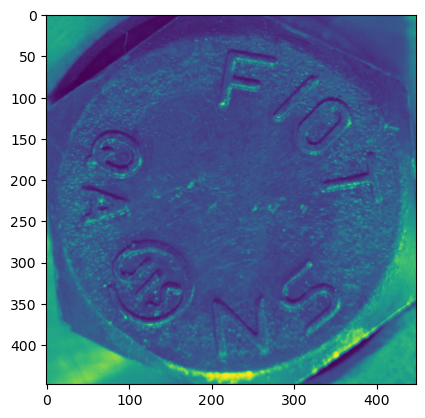

In [12]:
topic = T.ToPILImage()
imm1 = topic(images[1])
vimg, vlabels = dataiter.__next__()

plt.imshow(topic(vimg[1]))

In [22]:
def testAccuracy():
    net.eval()
    accuracy = 0.0
    total = 0.0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")
    x=[]
    y=[]
    np.array(x)
    np.array(y)
    # net=torch.load('')
    with torch.no_grad():
        for i, (images, labels) in enumerate(valid_loader, 0):
            #images, labels = dataiter.next()
            # 输入数据进行预测
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            predata = net(images)
            #predata, labedata = predict(net, valid_loader)
            loss=loss_func(predata, labels)
            loss += loss.item()
            x=np.append(x,[i[0] for i in labels.data.cpu().numpy()])
            y=np.append(y,np.array([i[0] for i in predata.data.cpu().numpy()]))
    preloss = np.mean(loss.data.cpu().numpy()) #preloss = loss/(i+1)
    r2 = 1 - np.mean((y - x) ** 2) / np.mean((x - x.mean()) ** 2)
    vmse = np.mean((y - x) ** 2)
    return(r2,preloss,vmse)

def train(num_epochs,device):
    import time
    start_time = time.process_time()
    best_accuracy = 0.0

    # Define your execution device
    #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")
    k=0
    predata=[]
    labeldata=[]
    mseloss=[]
    trainnum=[]
    epochout=[]
    epochV=[]
    vloss=[]
    vr2=[]
    # Convert model parameters and buffers to CPU or Cuda
    net.to(device)
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0
        for i, (images, labels) in enumerate(train_loader, 0):
            #images, labels = dataiter.next()
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            prediction = net(images)
            #print(prediction,labels)
            #print('Prediction data is:',prediction.data.cpu().numpy()[0])
            #print('label data is: ',labels.data.cpu().numpy())
            # 计算预测值与真值误差，注意参数顺序问题
            # 第一个参数为预测值，第二个为真值
            loss = loss_func(prediction, labels)*100
            # 开始优化步骤
            # 每次开始优化前将梯度置为0
            optimizer.zero_grad()
            # 误差反向传播
            loss.backward()
            # 按照最小loss优化参数
            optimizer.step()
            running_loss += loss.item()

            if (i+1) % 10 == 0:
                # print every 1000 (twice per epoch)
                #print(f"epoch #{epoch+1} Iteration #{i+1} loss: {loss_value}")
                print('[Epoch: %d/%d]- %d/%d | loss: %.3f | predict-True: %5d - %5d' %
                      (epoch + 1,num_epochs, i + 1,len(train_loader), running_loss / 10,prediction.data.cpu().numpy()[0]*116,labels.data.cpu().numpy()[0]*116))
                mseloss.append(running_loss/10)
                trainnum.append(i+1)
                epochout.append(epoch+1)
                result=pd.DataFrame({'epoch':epochout,'trainnum':trainnum,'loss':mseloss})
                result.to_csv("./result/"+casename+"/"+casename+"-result.csv",index=False,sep=',')
                # Tensorboard
                writer.add_scalar('Training loss',running_loss / 10,epoch * len(train_loader) + i)
                # writer.add_figure('predictions vs. actuals',
                #                   plot_classes_preds(net, inputs, labels),
                #                   global_step=epoch * len(trainloader) + i)
                # zero the loss
                running_loss = 0.0

            predata.append(prediction.data.cpu().numpy()[0])
            labeldata.append(labels.data.cpu().numpy()[0])

        r2,validloss,vmse = testAccuracy()
        vloss.append(validloss)
        vr2.append(r2)
        epochV.append(epoch+1)
        writer.add_scalar('valid_loss',validloss,epoch+1)
        vresult=pd.DataFrame({'epoch':epochV,'vloss':vloss,'vMSE':vmse,'vr2':vr2})
        vresult.to_csv("./result/"+casename+"/"+casename+"-result-valid.csv",index=False,sep=',')
        print('[Epoch: %d/%d] ======>| Valid Loss: %.3f ,MSE: %.3f | R^2 is %.3f' % (epoch+1,num_epochs,validloss,vmse,r2))
        if validloss <= 0.005:
            k +=1
            print('Validloss K=',k)
            if k == 3 and r2>0.90:
                torch.save(net, casename+'-OK'+'.pt')

            if k == 3 and r2>0.95:
                print('Traing is end, Due to Validloss consecutively less than 0.005.')
                break
        else: k = 0


    print('Finished Training')
    ttime=(np.array(epochout)-1)*len(train_loader)+np.array(trainnum)
    plt.figure()
    plt.legend()
    plt.grid(True)
    plt.ylim(0,0.1)
    plt.ylabel("Mean Squared Error")
    plt.xlabel("train times")
    plt.plot(ttime,mseloss)
    plt.savefig('tranloss.png', dpi=1200) 
    end_time = time.process_time()
    print("Use time:", (end_time-start_time)/3600)


In [14]:
def predict(model, device,dataloder):
    Vdataiter=iter(dataloder)
    vimg, vlabels = Vdataiter.next()
    model.to(device)
    with torch.no_grad():
        vimg=vimg.to(device)
        out = model(vimg)
        #_, pre = torch.max(out.data, 1)
        return out, vlabels

In [19]:
import torch
#import torchvision.transforms as T
import torchvision.transforms.transforms as T
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn

class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid())

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y
    
class Bottleneck(nn.Module):
    """
    __init__
        in_channel：残差块输入通道数
        out_channel：残差块输出通道数
        stride：卷积步长
        downsample：在_make_layer函数中赋值，用于控制shortcut图片下采样 H/2 W/2
    """
    expansion = 4   # 残差块第3个卷积层的通道膨胀倍率
    def __init__(self, in_channel, out_channel, stride=1, downsample=None):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=1, stride=1, bias=False)   # H,W不变。C: in_channel -> out_channel
        self.bn1 = nn.BatchNorm2d(num_features=out_channel)
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel, kernel_size=3, stride=stride, bias=False, padding=1)  # H/2，W/2。C不变
        self.bn2 = nn.BatchNorm2d(num_features=out_channel)
        self.conv3 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel*self.expansion, kernel_size=1, stride=1, bias=False)   # H,W不变。C: out_channel -> 4*out_channel
        self.bn3 = nn.BatchNorm2d(num_features=out_channel*self.expansion)
        self.relu = nn.ReLU(inplace=True)

        # Add SEBlock
        #self.seblock = SEBlock(out_channel*self.expansion)
        self.downsample = downsample

    def forward(self, x):
        identity = x    # 将原始输入暂存为shortcut的输出
        if self.downsample is not None:
            identity = self.downsample(x)   # 如果需要下采样，那么shortcut后:H/2，W/2。C: out_channel -> 4*out_channel(见ResNet中的downsample实现)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        # Apply SEBlock
        #out = self.seblock(out)

        out += identity     # 残差连接0 n
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    """
    __init__
        block: 堆叠的基本模块
        block_num: 基本模块堆叠个数,是一个list,对于resnet50=[3,4,6,3]
        num_classes: 全连接之后的分类特征维度

    _make_layer
        block: 堆叠的基本模块
        channel: 每个stage中堆叠模块的第一个卷积的卷积核个数，对resnet50分别是:64,128,256,512
        block_num: 当期stage堆叠block个数
        stride: 默认卷积步长
    """
    def __init__(self, block, block_num, num_classes):
        super(ResNet, self).__init__()
        self.in_channel = 64    # conv1的输出维度

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.in_channel, kernel_size=7, stride=2, padding=3, bias=False)     # H/2,W/2。C:3->64
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)     # H/2,W/2。C不变
        self.layer1 = self._make_layer(block=block, channel=64, block_num=block_num[0], stride=1)   # H,W不变。downsample控制的shortcut，out_channel=64x4=256
        self.layer2 = self._make_layer(block=block, channel=128, block_num=block_num[1], stride=2)  # H/2, W/2。downsample控制的shortcut，out_channel=128x4=512
        self.layer3 = self._make_layer(block=block, channel=256, block_num=block_num[2], stride=2)  # H/2, W/2。downsample控制的shortcut，out_channel=256x4=1024
        self.layer4 = self._make_layer(block=block, channel=512, block_num=block_num[3], stride=2)  # H/2, W/2。downsample控制的shortcut，out_channel=512x4=2048

        # Add SEBlocks after each residual block in the feature extraction layers
        self.seblock1 = SEBlock(64 * block.expansion)
        self.seblock2 = SEBlock(128 * block.expansion)
        self.seblock3 = SEBlock(256 * block.expansion)
        self.seblock4 = SEBlock(512 * block.expansion)

        self.fusion4 = MultiScaleFusion(512 * block.expansion, 512 * block.expansion)
        self.fusion3 = MultiScaleFusion(256 * block.expansion, 256 * block.expansion)
        self.fusion2 = MultiScaleFusion(128 * block.expansion, 128 * block.expansion)
        self.fusion1 = MultiScaleFusion(64, 64 * block.expansion)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))  # 将每张特征图大小->(1,1)，则经过池化后的输出维度=通道数
        self.fc1 = nn.Linear(in_features=512*block.expansion, out_features=1024) #in=2048,out=1024
        self.dropout = nn.Dropout(0.6) #dropout rate
        self.fc2 = nn.Linear(in_features=1024, out_features=512) #in=1024, out=1
        self.fc3 = nn.Linear(in_features=512, out_features=num_classes) #in=512, out=1
        #self.fc4 = nn.Linear(in_features=64, out_features=num_classes) #in=128, out=1

        # Upsampling layers for feature fusion
        self.upsample = lambda x: nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=None).to(x.device)
        #self.upsample = nn.functional.interpolate(scale_factor=2, mode='bilinear', align_corners=True)
        
        for m in self.modules():    # 权重初始化
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None   # 用于控制shorcut路的
        if stride != 1 or self.in_channel != channel*block.expansion:   # 对resnet50：conv2中特征图尺寸H,W不需要下采样/2，但是通道数x4，因此shortcut通道数也需要x4。对其余conv3,4,5，既要特征图尺寸H,W/2，又要shortcut维度x4
            downsample = nn.Sequential(
                nn.Conv2d(in_channels=self.in_channel, out_channels=channel*block.expansion, kernel_size=1, stride=stride, bias=False), # out_channels决定输出通道数x4，stride决定特征图尺寸H,W/2
                nn.BatchNorm2d(num_features=channel*block.expansion))

        layers = []  # 每一个convi_x的结构保存在一个layers列表中，i={2,3,4,5}
        layers.append(block(in_channel=self.in_channel, out_channel=channel, downsample=downsample, stride=stride)) # 定义convi_x中的第一个残差块，只有第一个需要设置downsample和stride
        self.in_channel = channel*block.expansion   # 在下一次调用_make_layer函数的时候，self.in_channel已经x4

        for _ in range(1, block_num):  # 通过循环堆叠其余残差块(堆叠了剩余的block_num-1个)
            layers.append(block(in_channel=self.in_channel, out_channel=channel))

        return nn.Sequential(*layers)   # '*'的作用是将list转换为非关键字参数传入

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x1 = self.layer1(x)
        x1 = self.seblock1(x1)
        #x1 = self.fusion1(x1)
        x2 = self.layer2(x1)
        x2 = self.seblock2(x2)
        #x2 = self.fusion2(x2)
        x3 = self.layer3(x2)
        x3 = self.seblock3(x3)
        #x3 = self.fusion3(x3)
        x4 = self.layer4(x3)
        x4 = self.seblock4(x4)
        #x4 = self.fusion4(x4)

        #x4 = self.fusion(x4)

        x = self.avgpool(x4)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

import torch
import torch.nn as nn

class MultiScaleFusion(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MultiScaleFusion, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=5, stride=1, padding=2)
        # 定义融合的卷积层
        self.fusion_conv = nn.Conv2d(3 * out_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        out = torch.cat([x1, x2, x3], dim=1)
        # 对融合的特征图进行卷积操作
        out = self.fusion_conv(out)
        out = self.relu(out)
        return out

# defin model

In [23]:
#from net import ResNet, Bottleneck
#from SEBlock import SEBlock
from loss_function import HuberLoss
#import net

# 输入输出的数据维度，这里都是1维
INPUT_FEATURE_DIM = 5000
# 隐含层中神经元的个数
#NEURON_NUM = 500
#OUTPUT_FEATURE_DIM = 1
# 学习率，越大学的越快，但也容易造成不稳定，准确率上下波动的情况
LEARNING_RATE = 0.01

# 定义模型

net = ResNet(block=Bottleneck, block_num=[3,4,6,3],num_classes=1)
#net = ResNet152(block=Bottleneck152,layers=[3, 4, 36, 3],num_classes=1,in_dim=1)
casename='case1'
writer = SummaryWriter("./log/"+casename) #tensorboard

#print(net)
writer.add_graph(net, images)
writer.close()

# 训练网络
# 这里也可以使用其它的优化方法
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
#optimizer = torch.optim.SGD(net.parameters(),lr=LEARNING_RATE)
# 定义一个误差计算方法
loss_func = HuberLoss(delta=1.0)
#loss_func = nn.MSELoss()
#loss_func = nn.CrossEntropyLoss() #定义交叉熵损失函数 交叉熵损失函数是用来衡量两个概率分布之间的距离的#nn.MSELoss()
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer

# main

In [24]:
 # Vdataiter=iter(valid_loader)
# vimg, vlabels = Vdataiter.next()
# print(vimg.shape)
# print(vlabels.shape)
# print(vlabels)
if __name__ == "__main__":

    
    torch.cuda.empty_cache()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")
    # Let's build our model
    train(500,device)
    print('Finished Training')
    #Epochごとのlossの保存
    torch.save(net, "./result/"+casename+"/"+casename+".pt")
    # 保存网络中的参数, 速度快，占空间少
    #torch.save(net.state_dict(),'case-1-p.pt')
    #--------------------------------------------------
    #针对上面一般的保存方法，加载的方法分别是：
    # model_dict=torch.load(PATH)
    # model_dict=model.load_state_dict(torch.load(PATH))
    # Test which classes performed well
    testAccuracy()

    # Let's load the model we just created and test the accuracy per label
    # model = net()
    # path = "myFirstModel.pth"
    # model.load_state_dict(torch.load(path))


[Epoch: 1/500]- 10/605 | loss: 1979.685 | predict-True:    42 -    98
[Epoch: 1/500]- 20/605 | loss: 5.243 | predict-True:    50 -    79
[Epoch: 1/500]- 30/605 | loss: 5.321 | predict-True:    45 -    11
[Epoch: 1/500]- 40/605 | loss: 4.678 | predict-True:    32 -    88
[Epoch: 1/500]- 50/605 | loss: 5.385 | predict-True:    49 -    80
[Epoch: 1/500]- 60/605 | loss: 4.534 | predict-True:    64 -    64
[Epoch: 1/500]- 70/605 | loss: 4.390 | predict-True:    95 -    71
[Epoch: 1/500]- 80/605 | loss: 4.133 | predict-True:    38 -     7
[Epoch: 1/500]- 90/605 | loss: 4.426 | predict-True:    51 -    52
[Epoch: 1/500]- 100/605 | loss: 3.951 | predict-True:    50 -    38
[Epoch: 1/500]- 110/605 | loss: 4.139 | predict-True:    51 -    57
[Epoch: 1/500]- 120/605 | loss: 3.941 | predict-True:    39 -    47
[Epoch: 1/500]- 130/605 | loss: 4.071 | predict-True:    65 -    49
[Epoch: 1/500]- 140/605 | loss: 3.899 | predict-True:    44 -    40
[Epoch: 1/500]- 150/605 | loss: 4.080 | predict-True: 

In [ ]:
torch.save(net, "./result/"+casename+"/"+casename+".pt")

# Visualization

In [ ]:
x=[]
y=[]
np.array(x)
np.array(y)
# net=torch.load('')
torch.cuda.empty_cache()
net.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
video=cv2.VideoWriter('./multibolt/video/valid.avi',-1,20,(448,448))  

with torch.no_grad():
    for i, (images, labels) in enumerate(valid_loader, 0):
        #images, labels = dataiter.next()
        # 输入数据进行预测
        # get the inputs
        images = Variable(images.to(device))
        labels = Variable(labels.to(device))
        predata = net(images)
        #predata, labedata = predict(net, valid_loader)
        loss=loss_func(predata, labels)
        loss += loss.item()
        x=np.append(x,[i[0] for i in labels.data.cpu().numpy()])
        y=np.append(y,np.array([i[0] for i in predata.data.cpu().numpy()]))
        preloss=loss/(i+1)

x0=x*116
y0=y*116

In [ ]:

x=np.linspace(0,120,120)
y=np.linspace(0,120,120)

from scipy.optimize import curve_fit
from scipy import stats
import uncertainties.unumpy as unp
import uncertainties as unc
import seaborn as sns

plt.figure()

plt.xlim(0,120)
plt.ylim(0,120)
#y_err1=1.1*train_label.data.cpu().numpy()
#y_err2=0.9*train_label.data.cpu().numpy()
#n = len(y)
xx=x0
yy=y0
n = len(yy)

def f(x, a, b):
    return np.multiply(a, x) + b

#popt, pcov = curve_fit(f, x, y)
popt, pcov = curve_fit(f, xx, yy)

# retrieve parameter values
a = popt[0]
b = popt[1]
print('Optimal Values')
print('a: ' + str(a))
print('b: ' + str(b))

# compute r^2
#r2 = 1.0-(sum((y0-f(x0,a,b))**2.0)/((n-1.0)*np.var(y,ddof=1)))
r2 = 1.0-(sum((yy-f(xx,a,b))**2.0)/((n-1.0)*np.var(y,ddof=1)))
print('R^2: ' + str(r2))
print('testdataNum:' + str(i+1))
print('preloss:' + str(preloss))

# calculate parameter confidence interval
a,b = unc.correlated_values(popt, pcov)
print('Uncertainty')
print('a: ' + str(a))
print('b: ' + str(b))



mse = np.mean((x0 - y0) ** 2)
rmse = np.sqrt(np.mean((x0 - y0) ** 2))
msle = np.mean((np.log1p(x0) - np.log1p(y0))** 2)
mae = np.mean(np.abs(x0 - y0))
r2 = 1 - np.mean((x0 - y0) ** 2) / np.mean((x0 - x0.mean()) ** 2)
print('MSE:=',mse,'| RMSE:',rmse,'|msle:',msle,'|mae:',mae,'|r2:',r2)

# calculate regression confidence interval
px=np.linspace(0,120,120)
py=a*px+b
nom = unp.nominal_values(py)
std = unp.std_devs(py)

def predband(x, xd, yd, p, func, conf=0.95):
    # x = requested points
    # xd = x data
    # yd = y data
    # p = parameters
    # func = function name
    alpha = 1.0 - conf    # significance
    N = xd.size          # data sample size
    var_n = len(p)  # number of parameters
    # Quantile of Student's t distribution for p=(1-alpha/2)
    q = stats.t.ppf(1.0 - alpha / 2.0, N - var_n)
    # Stdev of an individual measurement
    se = np.sqrt(1. / (N - var_n) * \
                 np.sum((yd - func(xd, *p)) ** 2))
    # Auxiliary definitions
    sx = (x - xd.mean()) ** 2
    sxd = np.sum((xd - xd.mean()) ** 2)
    # Predicted values (best-fit model)
    yp = func(x, *p)
    # Prediction band
    dy = q * se * np.sqrt(1.0+ (1.0/N) + (sx/sxd))
    # Upper & lower prediction bands.
    lpb, upb = yp - dy, yp + dy
    return lpb, upb

#plt.fill_between(df['temperature'], predictions['obs_ci_lower'], predictions['obs_ci_upper'], alpha=.1, label='Prediction interval')
# prediction band (95% confidence)

# plot the regression
#plt.plot(px, nom, c='black', label='Regression Line')

lpb, upb = predband(px, xx, yy, popt, f, conf=0.95)


#lpb=[x+25 for x in px]
#upb=[x-25 for x in px]

# uncertainty lines (95% confidence)
#plt.plot(px, nom - 1.96 * std, c='orange',\
#        label='95% Confidence Region')
#plt.plot(px, nom + 1.96 * std, c='orange')

# prediction band (95% confidence)
#plt.plot(px, lpb, 'k--',label='95% Prediction Band')
#plt.plot(px, upb, 'k--')
#plt.fill_between(px,lpb,upb, alpha=.1,)

# plot data

plt.plot(x0,y0,'ko',alpha=0.6,label='Data', mfc='none')


plt.plot(x, y, c='black')
#plt.plot(x*0.9,y,'k--',label='90% Error interval')
#plt.plot(x*1.1,y,'k--')
#plt.fill_between(x,x*1.1,x*0.9, alpha=.1)
plt.legend(loc='lower right')
plt.xlabel('Label data',fontsize=16)
plt.ylabel('Prediction data',fontsize=16)
text='$R^2$: {:.2f} \n$MSE$: {:.1f} \n$RMSE$: {:.1f} \n$MAE$: {:.1f}'.format(r2,mse,rmse,mae)
plt.text(5,85,text)
plt.savefig("./result/"+casename+"/"+casename+'predictpreload.png', dpi=1200)
plt.show()

In [ ]:
test_rdata, test_label = generate_dataset(testdir)
test_data = MyDataset(test_rdata, test_label, transform=transform)
test_loader = DataLoader(dataset=test_data, batch_size=4, shuffle=True)
x=[]
y=[]
np.array(x)
np.array(y)
net.eval()
# net=torch.load('')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader, 0):
        #images, labels = dataiter.next()
        # 输入数据进行预测
        # get the inputs
        images = Variable(images.to(device))
        labels = Variable(labels.to(device))
        predata = net(images)
        #predata, labedata = predict(net, valid_loader)
        loss=loss_func(predata, labels)
        loss += loss.item()
        x=np.append(x,[i[0] for i in labels.data.cpu().numpy()])
        y=np.append(y,np.array([i[0] for i in predata.data.cpu().numpy()]))
        preloss=loss/(i+1)


In [ ]:
x0=np.linspace(0,120,120)
y0=np.linspace(0,120,120)
plt.plot(x0, y0, c='black')
plt.plot(x*116,y*116,'ko',alpha=0.6,label='Data', mfc='none')
plt.xlabel('Label data',fontsize=16)
plt.ylabel('Prediction data',fontsize=16)
plt.show
plt.savefig("./result/"+casename+"/"+casename+'testother.png', dpi=1200)

In [ ]:
case27=torch.load('./result/case2-7/case2-7.pt')
print(case27)

# Creat video

In [ ]:
net27=torch.load('./result/case2-7/case2-7.pt')
x=[]
y=[]
np.array(x)
np.array(y)
# net=torch.load('')
torch.cuda.empty_cache()
net.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
codec = cv2.VideoWriter_fourcc(*"DIVX")
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
video=cv2.VideoWriter('valid.avi',fourcc,10,(448,448))  
c = (0,0,255)
with torch.no_grad():
    for i, (images, labels) in enumerate(valid_loader, 0):
        #images, labels = dataiter.next()
        # 输入数据进行预测
        # get the inputs
        images = Variable(images.to(device))
        
        labels = Variable(labels.to(device))
        predata = net27(images)
        #predata, labedata = predict(net, valid_loader)
        outproload=predata*116
        outlabel=labels*116
        erro=(outlabel-outproload)*100/outproload
        loss=loss_func(predata, labels)
        loss += loss.item()
        tmp = images[0,:,:,:].permute(1, 2, 0)
        rgb=tmp.to('cpu').detach().numpy()
        rgb = (rgb*255.0).astype(np.uint8)
        img = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)

        x=np.append(x,[i[0] for i in labels.data.cpu().numpy()])
        y=np.append(y,np.array([i[0] for i in predata.data.cpu().numpy()]))
        preloss=loss/(i+1)
        txt1 = 'Axial Force='+str(np.round(outproload.data.cpu().numpy()))+'/'+str(np.round(outlabel.data.cpu().numpy()))
        txt2= ' Error='+str(np.round(erro.data.cpu().numpy()))+'%'
        font = cv2.FONT_HERSHEY_SIMPLEX
        cat_size = cv2.getTextSize(txt, font, 2, 5)[0]
        cv2.rectangle(img, (25, 15), (430, 420), c , 2)
        #cv2.rectangle(img,(50,50 - cat_size[1] - 2),(box[0] + cat_size[0],400 - 2), c, -1)
        cv2.putText(img, txt1, (20, 50), font, 1, (255, 0, 0), thickness=2, lineType=cv2.LINE_AA)
        cv2.putText(img, txt2, (20, 80), font, 1, (255, 0, 0), thickness=2, lineType=cv2.LINE_AA)
        #plt.figure(figsize=(450,450))
        plt.imshow(img)
        video.write(img)
video.release()

In [ ]:
def unnorm(img, mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25]):
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img 

i, (images, labels) = enumerate(valid_loader, 0)
#a= unnorm(images[14,:,:,:]).permute(1, 2, 0)
print(images.shape)
print(a.shape[1])